In [ ]:
from sensible_raw.loaders import loader
import numpy as np
from sklearn.preprocessing import scale
from sklearn.svm import OneClassSVM
from collections import Counter, defaultdict
import sys
from datetime import datetime as dt


In [ ]:
from extractors.sms_extractor import Sms_extractor
##from stop_locations_extractor import Stop_locations_extractor
##from screen_extractor import Screen_extractor
##from facebook_friends_extractor import Facebook_friends_extractor
from extractors.bluetooth_extractor import Bluetooth_extractor
##from calllog_extractor import Calllog_extractor
##from location_extractor import Location_extractor
from extractors.big_five_extractor import Big_five_extractor

from preproc.outlier_detection import Outlier_detector

In [4]:
load_old_datasources = False

tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]} #in school
tc1 = {'hours': range(24), 'days': range(7), 'spans': [("17/05/14","01/06/14"), ("06/12/14", "21/12/14")]} #exam periods
tc2 = {'hours': range(24), 'days': range(7), 'spans': [("01/01/14","05/01/14"), ("25/01/14","02/02/14"), ("14/04/14","20/04/14"), ("21/06/14","30/08/14"), ("22/12/14", "31/12/14")]} #holiday

#sms = Sms_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
##stop_locations = Stop_locations_extractor()
##screen = Screen_extractor()
##facebook_friends = Facebook_friends_extractor()
bluetooth = Bluetooth_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
##calllog = Calllog_extractor()
##location = Location_extractor()
#big_five = Big_five_extractor()

 [sms] Building datasource from scratch ... <2014> january february march april may june september october november december ... succes! Saving.
[sms] Number of datapoints in range: 360400


### Build full JSON dataset

In [5]:
dataset_X = {}
dataset_Y = {}

for user in range(1000):
    
    if user%10 == 0:
        print user,
        
    datapoint_x = {}
    datapoint_y = {}
    
    try:
        datapoint_x.update(sms.main(user))
        #datapoint_x.update(stop_locations.main(user))
        #datapoint_x.update(screen.main(user))
        #datapoint_x.update(facebook_friends.main(user))
        datapoint_x.update(bluetooth.main(user))
        #datapoint_x.update(calllog.main(user))
        #datapoint_x.update(location.main(user))
        datapoint_y.update(big_five.main(user))
    except Exception as e:
        print "["+str(e)+"]",
        continue
        
    dataset_X[user] = datapoint_x
    dataset_Y[user] = datapoint_y

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


0 10 20 [User 25 not in dataset] 30 40 [User 41 not in dataset] 50 60 70 80 90 100 110 120 130 [User 134 not in dataset] 140 150 160 170 180 190

KeyboardInterrupt: 

In [7]:
dataset_X

{0: {'tc0_bluetooth_social_entropy': 2.4550049662988531,
  'tc0_sms_fractions_of_conversations_started': 0.3575638506876228,
  'tc0_sms_overall_received_responsiveness': -8.7074239935019762,
  'tc0_sms_overall_responsiveness': -9.2163180581478255,
  'tc0_sms_selectivity_in_responsiveness': -5.8401716056241426,
  'tc0_sms_traffic': 7.7030076824792362},
 1: {'tc0_bluetooth_social_entropy': 1.3243144578633761,
  'tc0_sms_fractions_of_conversations_started': 0.4811320754716981,
  'tc0_sms_overall_received_responsiveness': -9.4854705123033582,
  'tc0_sms_overall_responsiveness': -9.6109604731877951,
  'tc0_sms_selectivity_in_responsiveness': -8.1793977444482788,
  'tc0_sms_traffic': 5.6801726090170677},
 2: {'tc0_bluetooth_social_entropy': 2.0794723848094678,
  'tc0_sms_fractions_of_conversations_started': 0.3333333333333333,
  'tc0_sms_overall_received_responsiveness': -8.823353670220019,
  'tc0_sms_overall_responsiveness': -8.8315800841467613,
  'tc0_sms_selectivity_in_responsiveness': -4

In [23]:
print sms.main(user)
print bluetooth.main(user)

{'tc0_sms_overall_responsiveness': -9.1162261000623879, 'tc0_sms_selectivity_in_responsiveness': -3.4127315457328091, 'tc0_sms_overall_received_responsiveness': -8.7971113785200963, 'tc0_sms_fractions_of_conversations_started': 0.33719582850521435, 'tc0_sms_traffic': 8.7059937143079011}
{'tc0_sms_fractions_of_conversations_started': 2.6380304255258205}


### Convert to matrix and standardize

In [11]:
features_x = sorted(dataset_X.items()[0][1].keys())
features_y = ['openness','conscientiousness','extraversion','aggreeableness','neuroticism']

#features_x = filter(lambda x: int(x[2]) in [1,3], features_x)

X = []
Y = []
for k,v in dataset_X.items():
    X.append([v[f] for f in features_x])
for k,v in dataset_Y.items():
    Y.append([v[f] for f in features_y])
    
X_scaled = scale(np.array(X))
#Y_scaled = scale(np.array(Y))

### Remove outliers

In [12]:
out = Outlier_detector(X_scaled,threshold=-2)
outliers = out.main()

X_clean = np.delete(X_scaled,outliers,axis=0)
Y_clean = np.delete(Y,outliers,axis=0)

print X_scaled.shape
print X_clean.shape

np.savetxt("data/X.csv", X_clean, delimiter=",")
np.savetxt("data/Y.csv", Y_clean, delimiter=",")

(64, 5)
(64, 5)


[(0, 'tc0_sms_fractions_of_conversations_started'), (1, 'tc0_sms_overall_received_responsiveness'), (2, 'tc0_sms_overall_responsiveness'), (3, 'tc0_sms_selectivity_in_responsiveness'), (4, 'tc0_sms_traffic')]


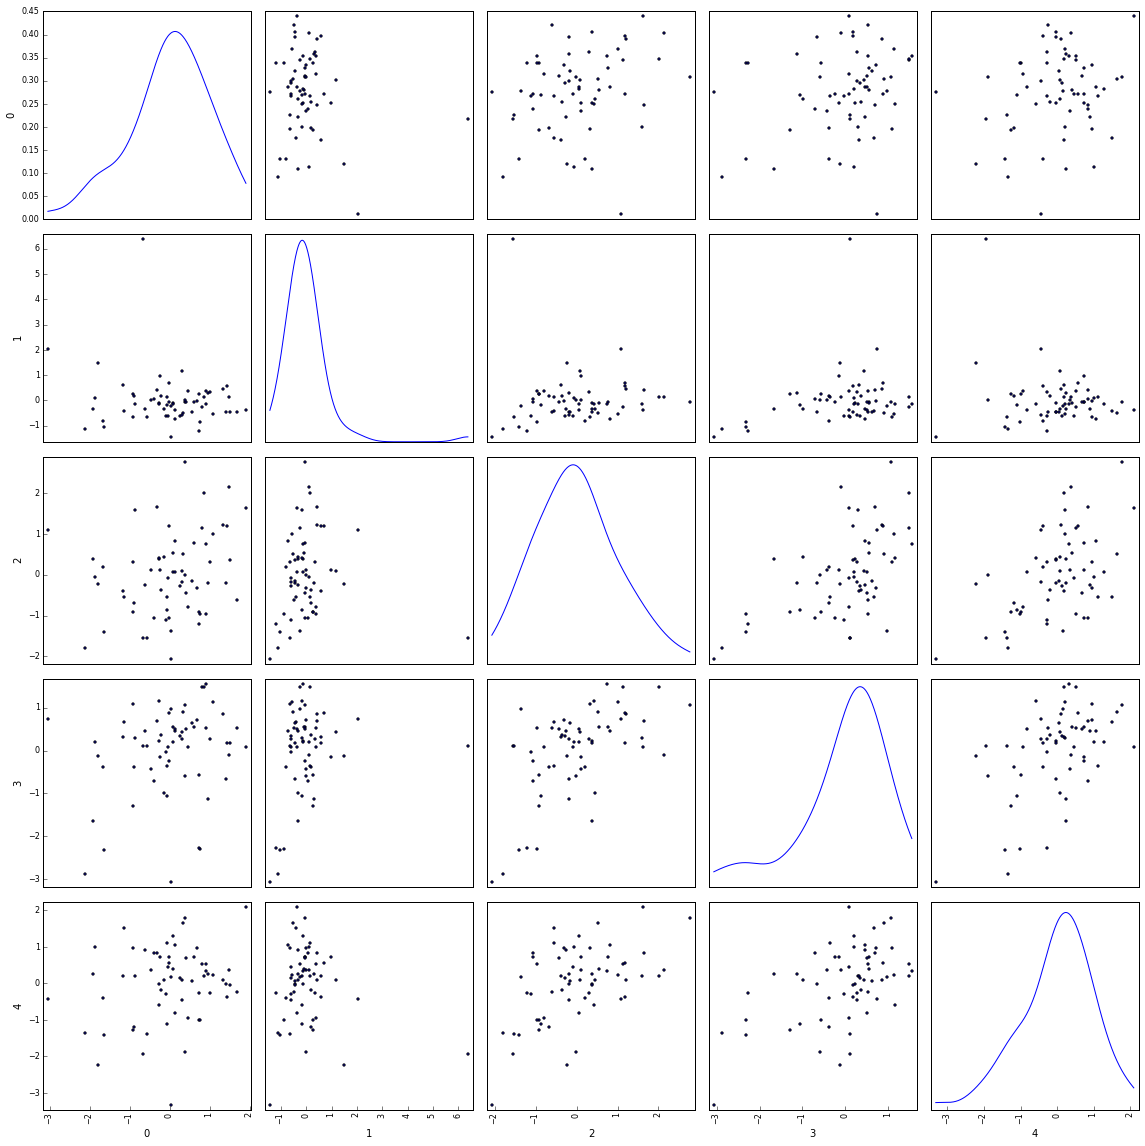

In [13]:
print zip(range(len(features_x)),features_x)
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
df = pd.DataFrame(X_clean)
pd.tools.plotting.scatter_matrix(df, alpha=1, figsize=(16,16), diagonal="kde")
plt.tight_layout()
plt.show()

In [10]:
features_x

['tc0_sms_fractions_of_conversations_started',
 'tc0_sms_overall_received_responsiveness',
 'tc0_sms_overall_responsiveness',
 'tc0_sms_selectivity_in_responsiveness',
 'tc0_sms_traffic']

In [79]:
print X_scaled.shape
print X_clean.shape

(772, 5)
(739, 5)


In [108]:
features_x

['tc0_sms_fractions_of_conversations_started',
 'tc0_sms_overall_received_responsiveness',
 'tc0_sms_overall_responsiveness',
 'tc0_sms_selectivity_in_responsiveness',
 'tc0_sms_traffic']

In [75]:
X.min()

-4.111045762890126

In [113]:
vals = [2,1,3,3,3,1,17,3,4,4,1,2,3]

In [114]:
np.mean(vals)

3.6153846153846154

In [115]:
for v in vals:
    try:
        themean = (themean+v)/2.0
    except:
        themean = v

In [132]:
component_combination = []#[(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)]

In [138]:
for i in range(5):
    for j in range(5):
        if j > i:
            component_combination.append((i,j))

SyntaxError: invalid syntax (<ipython-input-138-1793cdb9a4d1>, line 1)

In [148]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [154]:
np.delete(a,[0,2],axis=0)

array([[4, 5, 6]])

In [105]:
features_y

['openness',
 'extraversion',
 'neuroticism',
 'conscientiousness',
 'aggreeableness']